In [1]:
# Install base deps
# pip install pandas
# pip install bokeh
# pip install -U matplotlib

In [2]:
# W poprzednich naszych projektach, korzystaliśmy z biblioteky matplotlib, 
# Matplotlib jest jedna z najbardziej popularnych bibliotek do tworzenia wizualizacji w środowisku python, 
# jednak jego użytecznośc skupia się głównie na statycznych, dokładnych wizualizacjach które następnie można wykorzystać 
# np w prezentacjach lub raportach dla szefostwa. Jest też znacznie dłużej na rynku OpenSource, dzieki czemu ma gotowy szeroki wachlarz 
# rozwizan, i umozliwa szybkie i bezproblemowe tworzenie wizualizacji nawet dla poczatkujacych programistow i analitykow.
# 
# Bokeh z drugiej strony, skupiony jest na intekatycnych wizualizajach, które możemy integrować np ze stronami internetowymi. Jego 
# architektura, pozwala na szybkie procesowania dużych zbiorów danych a następnie wyświetlanie ich użytkownikowi. Bokeh opera się na 
# generowaniu kodu serwer-side który następnie renderowany jest przy pomocy HTML i JS. Dzięki temu jest świetnym rozwiazaniem do 
# wykorzystania w różnych aplikacjach i dashboardach wyświetlanych w przegladarkach internetowych.
# 
# Patrzac na statysktyki
# Github
# Matplotlib 21k stars, 7.8k forks na github
# Bokeh 19kstars, 4.8k forks na github
# StackOverflow
# Bokeh 5k tematow
# Matplotlib 72k tematow! 

In [3]:
# No, ok, ale zobaczmy co da się zrobić z tymi bibliotekami.
# Zacznimy od prostego wykresu dla tego samego zbioru danych, a najczesciej jestesmy proszeni o dane finansowe
# wiec :shurg: zacznijmy od tego. 

In [4]:
# Daily sales report as matplotlib
import pandas as pd

# Parse data
visa_df = pd.read_csv("./datasets/visa_stocks.csv")
visa_df['Date'] = pd.to_datetime(visa_df['Date'])
visa_df.set_index('Date', inplace=True)
visa_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-03-19,14.875000,17.250000,13.7500,14.1250,12.579995,708486000
2008-03-20,14.600000,16.250000,14.3750,16.0875,14.327834,198985200
2008-03-24,16.809999,16.924999,14.7500,14.9325,13.299167,149566400
2008-03-25,15.145000,16.062500,14.9550,15.8125,14.082910,87092000
2008-03-26,15.682500,16.120001,15.3925,15.9900,14.240999,43111600


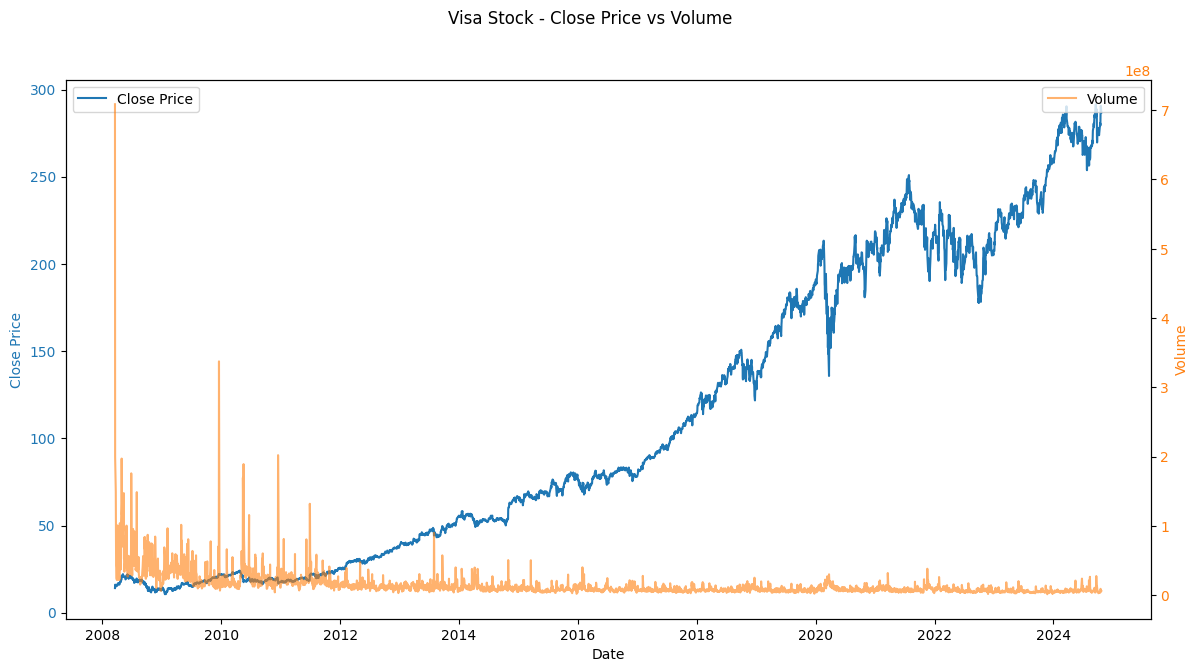

In [5]:
# Sameple plot using matplotlib
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(visa_df.index, visa_df['Close'], label='Close Price', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(visa_df.index, visa_df['Volume'], label='Volume', color='tab:orange', alpha=0.6)
ax2.set_ylabel('Volume', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.suptitle('Visa Stock - Close Price vs Volume')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [6]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Range1d, LinearAxis
import pandas as pd

# Index do baseline value 100
visa_df['Close_Indexed'] = (visa_df['Close'] / visa_df['Close'].iloc[0]) * 100
visa_df['Volume_Indexed'] = (visa_df['Volume'] / visa_df['Volume'].iloc[0]) * 100

output_notebook()
source = ColumnDataSource(data=dict(date=visa_df.index, close=visa_df['Close_Indexed'], volume=visa_df['Volume_Indexed']))

# Wykres dla Close Price
p = figure(title="Visa Stock - Indexed Close Price and Volume (Base 100)", x_axis_type="datetime", height=400, width=900)
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Indexed Value (Base 100)"
p.line('date', 'close', source=source, line_width=2, color="blue", legend_label="Close Price (Indexed)")

# Wykre dla Volume
p.extra_y_ranges = {"Volume": Range1d(start=visa_df['Volume_Indexed'].min(), end=visa_df['Volume_Indexed'].max())}
volume_axis = LinearAxis(y_range_name="Volume", axis_label="Volume (Indexed)")
p.add_layout(volume_axis, 'right')
p.line('date', 'volume', source=source, line_width=2, color="orange", legend_label="Volume (Indexed)", y_range_name="Volume")

p.legend.location = "top_left"
show(p)

Loading BokehJS ...

In [9]:
# A teraz dodajmy coś wiecej, dodajmy interaktywny slider
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Range1d, LinearAxis, DateRangeSlider, CustomJS
from bokeh.layouts import column
import pandas as pd

p = figure(title="Visa Stock - Indexed Close Price and Volume (Base 100)", x_axis_type="datetime", height=400, width=900)
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Indexed Value (Base 100)"

# Wykres dla Close Price
p.line('date', 'close', source=source, line_width=2, color="blue", legend_label="Close Price (Indexed)")
p.extra_y_ranges = {"Volume": Range1d(start=visa_df['Volume_Indexed'].min(), end=visa_df['Volume_Indexed'].max())}
volume_axis = LinearAxis(y_range_name="Volume", axis_label="Volume (Indexed)")
p.add_layout(volume_axis, 'right')

# Wykres dla Volume
p.line('date', 'volume', source=source, line_width=2, color="orange", legend_label="Volume (Indexed)", y_range_name="Volume")

p.legend.location = "top_left"

# Create a DateRangeSlider
date_range_slider = DateRangeSlider(
    title="Date Range", 
    start=visa_df.index.min(), 
    end=visa_df.index.max(), 
    value=(visa_df.index.min(), visa_df.index.max()), 
    step=1
)

# JavaScript callback do interakcji z sliderem
callback = CustomJS(args=dict(source=source, slider=date_range_slider), code="""
    const data = source.data;
    const start = new Date(slider.value[0]);
    const end = new Date(slider.value[1]);
    const date = data['date'];
    const close = data['close'];
    const volume = data['volume'];

    const new_date = [];
    const new_close = [];
    const new_volume = [];
    for (let i = 0; i < date.length; i++) {
        if (date[i] >= start && date[i] <= end) {
            new_date.push(date[i]);
            new_close.push(close[i]);
            new_volume.push(volume[i]);
        }
    }
    data['date'] = new_date;
    data['close'] = new_close;
    data['volume'] = new_volume;

    source.change.emit();
""")

# Attach the callback to the slider
date_range_slider.js_on_change("value", callback)

# Display layout
layout = column(date_range_slider, p)
show(layout)


In [1]:
# To teraz popracujmy na czymś podobnym do tego co mieliśmy. 
# Zanieczyszczenie wody i powietrza dane znowu z Kaggle

In [12]:
import pandas as pd

# Parse data
pollution_df = pd.read_csv("./datasets/pollution.csv", quotechar='"', skipinitialspace=True)
pollution_df = pollution_df.replace(r'^\s*$', pd.NA, regex=True).dropna(how='any')
pollution_df.head()

,City,Region,Country,AirQuality,WaterPollution
0,New York City,New York,United States of America,46.816038,49.504950
1,"Washington, D.C.",District of Columbia,United States of America,66.129032,49.107143
2,San Francisco,California,United States of America,60.514019,43.000000
4,Los Angeles,California,United States of America,36.621622,61.299435
5,Bern,Canton of Bern,Switzerland,94.318182,12.500000


In [38]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Select, CustomJS
from bokeh.layouts import column, row

output_notebook()
data_dict = {
    'City': pollution_df['City'].astype(str),
    'Region': pollution_df['Region'].astype(str),
    'Country': pollution_df['Country'].astype(str),
    'AirQuality': pollution_df['AirQuality'],
    'WaterPollution': pollution_df['WaterPollution']
}
# Data Sources
source = ColumnDataSource(data=data_dict)
original_source = ColumnDataSource(data=data_dict)

# Plot
p = figure(
    title="Air Quality vs Water Pollution by Country",
    width=800,
    height=400,
    x_axis_label="Air Quality",
    y_axis_label="Water Pollution",
    tools="pan,box_zoom,reset,save"
)

# Scatter
scatter = p.circle(x='AirQuality', y='WaterPollution', size=10, source=source, color='navy', alpha=0.7)

# Tools
hover = HoverTool()
hover.tooltips = [
    ("City", "@City"),
    ("Region", "@Region"),
    ("Country", "@Country"),
    ("Air Quality", "@AirQuality"),
    ("Water Pollution", "@WaterPollution")
]
p.add_tools(hover)

# Selector for Country
country_options = pollution_df['Country'].unique().tolist()
country_select = Select(title="Country", value=country_options[0], options=country_options)

callback = CustomJS(args=dict(source=source, original_source=original_source, country_select=country_select), code="""
    const selected_country = country_select.value;
    const original_data = original_source.data;
    const data = source.data;
    
    data['City'] = [];
    data['Region'] = [];
    data['Country'] = [];
    data['AirQuality'] = [];
    data['WaterPollution'] = [];
    
    for (let i = 0; i < original_data['Country'].length; i++) {
        if (original_data['Country'][i] === selected_country) {
            data['City'].push(original_data['City'][i]);
            data['Region'].push(original_data['Region'][i]);
            data['Country'].push(original_data['Country'][i]);
            data['AirQuality'].push(original_data['AirQuality'][i]);
            data['WaterPollution'].push(original_data['WaterPollution'][i]);
        }
    }
    
    source.change.emit();
""")

country_select.js_on_change('value', callback)

layout = column(country_select, p)
show(layout)

Loading BokehJS ...